In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Conv2DTranspose

In [2]:
def load_images_from_directory(directory, size=(32, 32)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            img = img.resize(size)
            img = np.array(img) / 255.0
            images.append(img)
    return np.array(images)

In [3]:
train_noisy_dir = 'C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Train\\Noisy'
train_clean_dir = 'C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Train\\Clean'
test_noisy_dir = 'C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Test\\Noisy'
test_clean_dir = 'C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Test\\Clean'

In [4]:
train_noisy_images = load_images_from_directory(train_noisy_dir)
train_clean_images = load_images_from_directory(train_clean_dir)
test_noisy_images = load_images_from_directory(test_noisy_dir)
test_clean_images = load_images_from_directory(test_clean_dir)

print("Train Noisy Images Shape: ", train_noisy_images.shape)
print("Train Clean Images Shape: ", train_clean_images.shape)
print("Test Noisy Images Shape: ", test_noisy_images.shape)
print("Test Clean Images Shape: ", test_clean_images.shape)

train_noisy_images = train_noisy_images.astype('float32')
train_clean_images = train_clean_images.astype('float32')
test_noisy_images = test_noisy_images.astype('float32')
test_clean_images = test_clean_images.astype('float32')

Train Noisy Images Shape:  (258, 32, 32, 3)
Train Clean Images Shape:  (258, 32, 32, 3)
Test Noisy Images Shape:  (227, 32, 32, 3)
Test Clean Images Shape:  (227, 32, 32, 3)


In [5]:
def build_advanced_denoising_model(input_shape):
    input_img = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    encoded = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(encoded)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
    
    model = tf.keras.models.Model(input_img, decoded)
    return model

In [6]:
model = build_advanced_denoising_model((32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.01, patience=10, min_lr=0.000001)
]

history = model.fit(train_noisy_images, train_clean_images, epochs=100, batch_size=32, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)

denoised_images = model.predict(test_noisy_images)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0900 - val_loss: 0.3028 - learning_rate: 0.0100
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.0301 - val_loss: 0.3017 - learning_rate: 0.0100
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.0267 - val_loss: 0.1327 - learning_rate: 0.0100
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 598ms/step - loss: 0.0264 - val_loss: 0.1498 - learning_rate: 0.0100
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 582ms/step - loss: 0.0248 - val_loss: 0.1911 - learning_rate: 0.0100
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 592ms/step - loss: 0.0234 - val_loss: 0.2354 - learning_rate: 0.0100
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 601ms/step - loss: 0.0227 - val_loss: 0.0436 - learning_rate: 0.0100
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 614ms/step - loss: 0.0217 - val_loss: 0.0500 - learning_rate: 0.0100
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - loss: 0.0235 - val_loss: 0.0690 - learning_rate: 0.0100
Epoch 10/100
9/9 ━━━━━━━━

In [7]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

psnr_scores = [calculate_psnr(test_clean_images[i], denoised_images[i]) for i in range(len(test_clean_images))]
avg_psnr = np.mean(psnr_scores)
mse_score = np.mean((test_clean_images - denoised_images) ** 2)
mae_score = np.mean(np.abs(test_clean_images - denoised_images))

print(f'Average PSNR: {avg_psnr}')
print(f'MSE: {mse_score}')
print(f'MAE: {mae_score}')

Average PSNR: 16.380148088505436
MSE: 0.029611218720674515
MAE: 0.14122359454631805


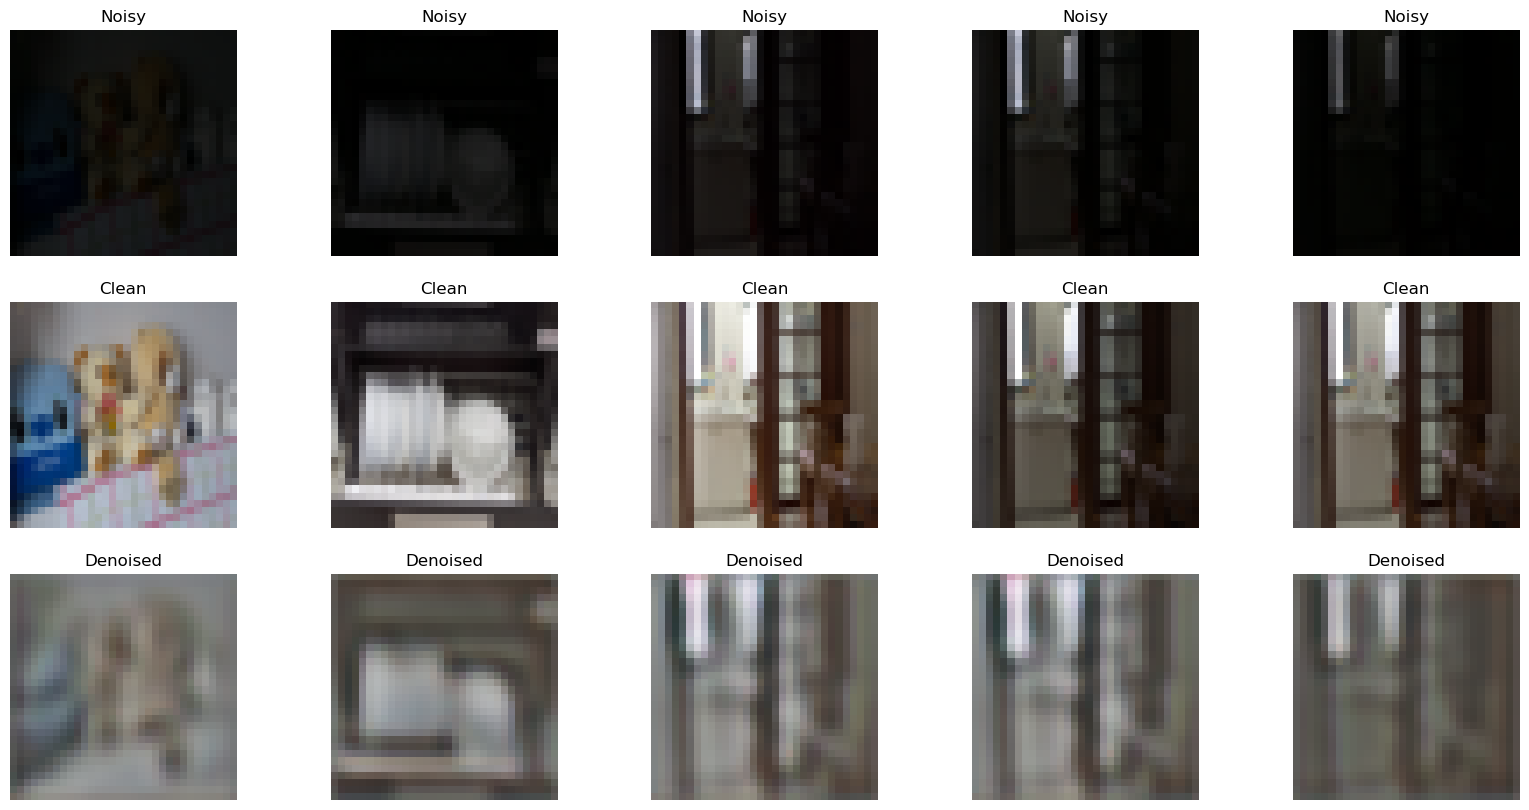

In [8]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_noisy_images[i])
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_clean_images[i])
    plt.title("Clean")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised")
    plt.axis("off")
plt.show()